In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, to_date, mean, rank, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression, GBTRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Initialize Spark session with dynamic allocation
spark = SparkSession.builder \
    .appName("LoanRiskAssessment") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .getOrCreate()

# Load data with schema inference optimized for parallel reads
loan_df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .csv("./Loan.csv")

# loan_df.show()

## **Data Cleaning and Preprocessing**

In [3]:
# Drop duplicate rows
loan_df = loan_df.dropDuplicates()
loan_df.show()

+---------------+---+------------+-----------+----------------+--------------+----------+----------+------------+-------------+------------------+-------------------+-------------------+-------------------------+-----------------------+-----------------------+-------------------+-----------------+------------------+--------------------+--------------+---------------------+---------------------+----------------------+-----------+----------------+------------------+--------------------------+---------+--------+-------------------+-------------------+------------------+----------------------+------------+------------------+
|ApplicationDate|Age|AnnualIncome|CreditScore|EmploymentStatus|EducationLevel|Experience|LoanAmount|LoanDuration|MaritalStatus|NumberOfDependents|HomeOwnershipStatus|MonthlyDebtPayments|CreditCardUtilizationRate|NumberOfOpenCreditLines|NumberOfCreditInquiries|  DebtToIncomeRatio|BankruptcyHistory|       LoanPurpose|PreviousLoanDefaults|PaymentHistory|LengthOfCreditHist

In [4]:
# Convert the dtype of the ApplicationDate column to date
loan_df = loan_df.withColumn("ApplicationDate", to_date("ApplicationDate", "yyyy-MM-dd"))
print(loan_df.dtypes)

[('ApplicationDate', 'date'), ('Age', 'int'), ('AnnualIncome', 'int'), ('CreditScore', 'int'), ('EmploymentStatus', 'string'), ('EducationLevel', 'string'), ('Experience', 'int'), ('LoanAmount', 'int'), ('LoanDuration', 'int'), ('MaritalStatus', 'string'), ('NumberOfDependents', 'int'), ('HomeOwnershipStatus', 'string'), ('MonthlyDebtPayments', 'int'), ('CreditCardUtilizationRate', 'double'), ('NumberOfOpenCreditLines', 'int'), ('NumberOfCreditInquiries', 'int'), ('DebtToIncomeRatio', 'double'), ('BankruptcyHistory', 'int'), ('LoanPurpose', 'string'), ('PreviousLoanDefaults', 'int'), ('PaymentHistory', 'int'), ('LengthOfCreditHistory', 'int'), ('SavingsAccountBalance', 'int'), ('CheckingAccountBalance', 'int'), ('TotalAssets', 'int'), ('TotalLiabilities', 'int'), ('MonthlyIncome', 'double'), ('UtilityBillsPaymentHistory', 'double'), ('JobTenure', 'int'), ('NetWorth', 'int'), ('BaseInterestRate', 'double'), ('InterestRate', 'double'), ('MonthlyLoanPayment', 'double'), ('TotalDebtToIncom

In [5]:
# Identify all numerical columns in the DataFrame
numerical_columns = [column for column, dtype in loan_df.dtypes if dtype in ("int", "double")]

# Fill null values in numerical columns with their respective mean
mean_values = loan_df.select([mean(col).alias(col) for col in numerical_columns]).collect()[0].asDict()
loan_df = loan_df.fillna(mean_values)

In [6]:
# Filter out invalid data entries
loan_df = loan_df.filter((col("Age") >= 18) & 
                         (col("LoanAmount") > 0) & 
                         (col("AnnualIncome") >= 0) & 
                         (col("CreditScore").between(300, 850)))

In [7]:
# Correct typos in EmploymentStatus column
loan_df = loan_df.withColumn(
    "EmploymentStatus",
    when(col("EmploymentStatus") == "unemployd", "unemployed")
    .when(col("EmploymentStatus") == "self-empl", "self-employed")
    .otherwise(col("EmploymentStatus"))
)
print("The typos in the EmploymentStatus column have been successfully corrected.\n")

# Check for unique values in string columns
for column in loan_df.columns:
    if dict(loan_df.dtypes)[column] not in ("int", "double", "date"):
        print(f"Unique values in column '{column}':")
#         loan_df.select(column).distinct().show()
        loan_df.groupBy(column).count().show() 

The typos in the EmploymentStatus column have been successfully corrected.

Unique values in column 'EmploymentStatus':
+----------------+-----+
|EmploymentStatus|count|
+----------------+-----+
|        Employed|17036|
|   Self-Employed| 1573|
|      Unemployed| 1391|
+----------------+-----+

Unique values in column 'EducationLevel':
+--------------+-----+
|EducationLevel|count|
+--------------+-----+
|   High School| 5908|
|     Associate| 4034|
|        Master| 3050|
|     Doctorate|  954|
|      Bachelor| 6054|
+--------------+-----+

Unique values in column 'MaritalStatus':
+-------------+-----+
|MaritalStatus|count|
+-------------+-----+
|      Married|10041|
|     Divorced| 2882|
|      Widowed|  999|
|       Single| 6078|
+-------------+-----+

Unique values in column 'HomeOwnershipStatus':
+-------------------+-----+
|HomeOwnershipStatus|count|
+-------------------+-----+
|                Own| 3938|
|               Rent| 6087|
|              Other| 2036|
|           Mortgage|

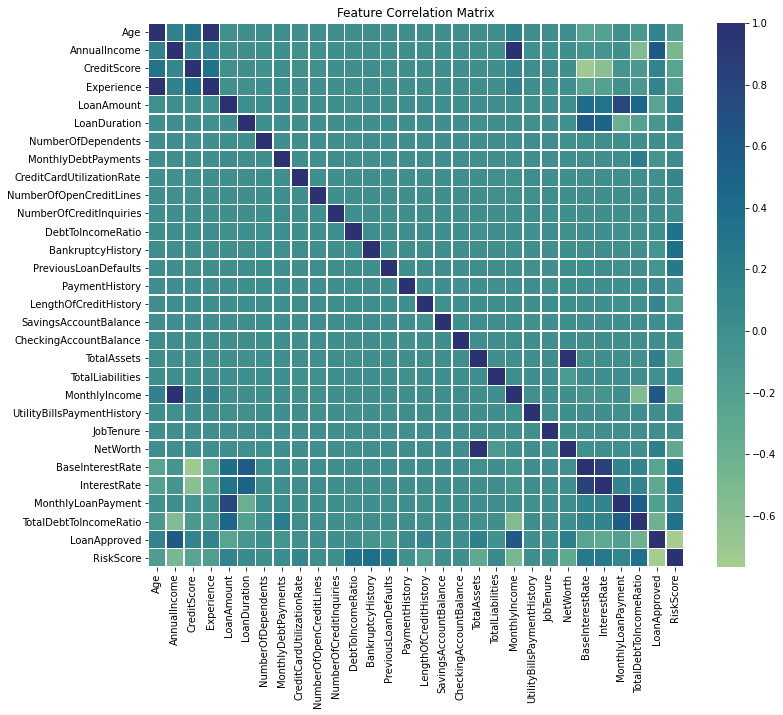

In [8]:
# Assemble numerical features into a vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features_vector")
df_vector = assembler.transform(loan_df).select("features_vector")

# Compute the Pearson correlation matrix
corr_matrix = Correlation.corr(df_vector, "features_vector").collect()[0][0].toArray()

# Plot the heatmap
corr_df_pd = pd.DataFrame(corr_matrix, index=numerical_columns, columns=numerical_columns)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df_pd, annot=False, cmap="crest", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=90)
plt.show()

In [9]:
# Drop highly correlated features and irrelevant features
loan_df = loan_df.drop("Experience", "TotalAssets", "MonthlyIncome", "ApplicationDate")
loan_df.show()

+---+------------+-----------+----------------+--------------+----------+------------+-------------+------------------+-------------------+-------------------+-------------------------+-----------------------+-----------------------+-------------------+-----------------+------------------+--------------------+--------------+---------------------+---------------------+----------------------+----------------+--------------------------+---------+--------+-------------------+-------------------+------------------+----------------------+------------+------------------+
|Age|AnnualIncome|CreditScore|EmploymentStatus|EducationLevel|LoanAmount|LoanDuration|MaritalStatus|NumberOfDependents|HomeOwnershipStatus|MonthlyDebtPayments|CreditCardUtilizationRate|NumberOfOpenCreditLines|NumberOfCreditInquiries|  DebtToIncomeRatio|BankruptcyHistory|       LoanPurpose|PreviousLoanDefaults|PaymentHistory|LengthOfCreditHistory|SavingsAccountBalance|CheckingAccountBalance|TotalLiabilities|UtilityBillsPayment

In [10]:
# Identify categorical columns
categorical_columns = [column for column, dtype in loan_df.dtypes if dtype == "string"]

# Create StringIndexer and OneHotEncoder stages for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="skip") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded", dropLast=False) for col in categorical_columns]

# Combine all stages into a single pipeline
pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline and transform the DataFrame
encoded_df = pipeline.fit(loan_df).transform(loan_df)

# Drop the original categorical columns
encoded_df = encoded_df.drop(*categorical_columns)

# Display the resulting DataFrame with encoded features
encoded_df.select(*[f"{col}_encoded" for col in categorical_columns]).show(5)

+------------------------+----------------------+---------------------+---------------------------+-------------------+
|EmploymentStatus_encoded|EducationLevel_encoded|MaritalStatus_encoded|HomeOwnershipStatus_encoded|LoanPurpose_encoded|
+------------------------+----------------------+---------------------+---------------------------+-------------------+
|           (3,[0],[1.0])|         (5,[1],[1.0])|        (4,[2],[1.0])|              (4,[0],[1.0])|      (5,[4],[1.0])|
|           (3,[0],[1.0])|         (5,[0],[1.0])|        (4,[0],[1.0])|              (4,[2],[1.0])|      (5,[0],[1.0])|
|           (3,[0],[1.0])|         (5,[3],[1.0])|        (4,[1],[1.0])|              (4,[1],[1.0])|      (5,[0],[1.0])|
|           (3,[0],[1.0])|         (5,[2],[1.0])|        (4,[1],[1.0])|              (4,[1],[1.0])|      (5,[1],[1.0])|
|           (3,[0],[1.0])|         (5,[1],[1.0])|        (4,[0],[1.0])|              (4,[2],[1.0])|      (5,[3],[1.0])|
+------------------------+--------------

In [11]:
# Partition by LoanPurpose_indexed and order by LoanAmount in descending order
window_spec = Window.partitionBy("LoanPurpose_encoded").orderBy(col("LoanAmount").desc())

# Add a new column "ApplicationRank" based on LoanAmount ranking within each LoanPurpose group
ranked_df = encoded_df.withColumn("ApplicationRank", rank().over(window_spec))

# Display selected columns to verify the ranking
ranked_df.select("LoanPurpose_encoded", "LoanAmount", "ApplicationRank").show()

+-------------------+----------+---------------+
|LoanPurpose_encoded|LoanAmount|ApplicationRank|
+-------------------+----------+---------------+
|      (5,[0],[1.0])|    158686|              1|
|      (5,[0],[1.0])|    136565|              2|
|      (5,[0],[1.0])|    125733|              3|
|      (5,[0],[1.0])|    118908|              4|
|      (5,[0],[1.0])|    115410|              5|
|      (5,[0],[1.0])|    112253|              6|
|      (5,[0],[1.0])|    101914|              7|
|      (5,[0],[1.0])|    100414|              8|
|      (5,[0],[1.0])|     99955|              9|
|      (5,[0],[1.0])|     98803|             10|
|      (5,[0],[1.0])|     93690|             11|
|      (5,[0],[1.0])|     93361|             12|
|      (5,[0],[1.0])|     87613|             13|
|      (5,[0],[1.0])|     87606|             14|
|      (5,[0],[1.0])|     86770|             15|
|      (5,[0],[1.0])|     85378|             16|
|      (5,[0],[1.0])|     84004|             17|
|      (5,[0],[1.0])

In [12]:
# Split the dataset into training and test sets
train_df, test_df = encoded_df.randomSplit([0.8, 0.2], seed=42)

# Extract features (X) and target variables (y) for both classification and regression tasks
classification_target = "LoanApproved"
regression_target = "RiskScore"
feature_columns = [col for col in encoded_df.columns if col not in [classification_target, regression_target]]

X_train = train_df.select(*feature_columns)
y_train_clf = train_df.select(classification_target)
y_train_reg = train_df.select(regression_target)

X_test = test_df.select(*feature_columns)
y_test_clf = test_df.select(classification_target)
y_test_reg = test_df.select(regression_target)

In [13]:
# Identify numerical columns
numerical_columns = [col for col in feature_columns if dict(encoded_df.dtypes)[col] in ['int', 'double']]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="assembled_features")
X_train_assembled = assembler.transform(X_train)
X_test_assembled = assembler.transform(X_test)

# Apply StandardScaler to normalize the features
scaler =  MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features")
scaler_model = scaler.fit(X_train_assembled)

X_train_scaled = scaler_model.transform(X_train_assembled)
X_test_scaled = scaler_model.transform(X_test_assembled)

# Replace original features with normalized ones
X_train_normalized = X_train_scaled.select("scaled_features")
X_test_normalized = X_test_scaled.select("scaled_features")

In [14]:
# Add index to y_train_clf, y_train_reg and X_train_scaled to join them later
X_train_scaled = X_train_scaled.withColumn("row_index", monotonically_increasing_id())
y_train_clf = y_train_clf.withColumn("row_index", monotonically_increasing_id())
y_train_reg = y_train_reg.withColumn("row_index", monotonically_increasing_id())

train_data_clf = X_train_scaled.join(y_train_clf, on="row_index", how="inner") \
       .select(col("scaled_features").alias("features"), col(classification_target).cast("double").alias("label"))

train_data_reg = X_train_scaled.join(y_train_reg, on="row_index", how="inner") \
       .select(col("scaled_features").alias("features"), col(regression_target).cast("double").alias("label"))

# Repeat for test data
X_test_scaled = X_test_scaled.withColumn("row_index", monotonically_increasing_id())
y_test_clf = y_test_clf.withColumn("row_index", monotonically_increasing_id())
y_test_reg = y_test_reg.withColumn("row_index", monotonically_increasing_id())

test_data_clf = X_test_scaled.join(y_test_clf, on="row_index", how="inner") \
       .select(col("scaled_features").alias("features"), col(classification_target).cast("double").alias("label"))

test_data_reg = X_test_scaled.join(y_test_reg, on="row_index", how="inner") \
       .select(col("scaled_features").alias("features"), col(regression_target).cast("double").alias("label"))

## **Classification Task - Loan Approval Prediction**

### Support Vector Classifier

In [15]:
# Initialize the Support Vector classifier
sv = LinearSVC(featuresCol="features", labelCol="label")

# Train the model
sv_model = sv.fit(train_data_clf)

# Make predictions
predictions_sv = sv_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_sv = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_sv = accuracy_evaluator_sv.evaluate(predictions_sv)

precision_evaluator_sv = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_sv = precision_evaluator_sv.evaluate(predictions_sv)

recall_evaluator_sv = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_sv = recall_evaluator_sv.evaluate(predictions_sv)

f1_evaluator_sv =MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_sv = f1_evaluator_sv.evaluate(predictions_sv)

print("Support Vector Classifier - Classification Report")
print(f"Accuracy : {accuracy_sv:.4f}")
print(f"Precision: {precision_sv:.4f}")
print(f"Recall   : {recall_sv:.4f}")
print(f"F1 Score : {f1_sv:.4f}")

Support Vector Classifier - Classification Report
Accuracy : 0.9512
Precision: 0.9508
Recall   : 0.9512
F1 Score : 0.9509


### Decision Tree Classifier

In [16]:
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)

# Train the model
dt_model = dt.fit(train_data_clf)

# Make predictions on the test set
predictions_dt = dt_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_dt = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_dt = accuracy_evaluator_dt.evaluate(predictions_dt)

precision_evaluator_dt = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_dt = precision_evaluator_dt.evaluate(predictions_dt)

recall_evaluator_dt = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_dt = recall_evaluator_dt.evaluate(predictions_dt)

f1_evaluator_dt = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_dt = f1_evaluator_dt.evaluate(predictions_dt)

print("Decision Tree Classifier - Classification Report")
print(f"Accuracy : {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall   : {recall_dt:.4f}")
print(f"F1 Score : {f1_dt:.4f}")

# Print the tree structure
print("\nDecision Tree Structure:")
print(dt_model.toDebugString)

Decision Tree Classifier - Classification Report
Accuracy : 0.8926
Precision: 0.8906
Recall   : 0.8926
F1 Score : 0.8914

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f5574296163a, depth=5, numNodes=45, numClasses=2, numFeatures=30
  If (feature 24 <= 0.038235913224876975)
   If (feature 1 <= 0.1499327083966739)
    If (feature 22 <= 0.3522315115154785)
     If (feature 14 <= 0.375)
      If (feature 22 <= 0.21897230454993438)
       Predict: 1.0
      Else (feature 22 > 0.21897230454993438)
       Predict: 0.0
     Else (feature 14 > 0.375)
      If (feature 11 <= 0.5)
       Predict: 1.0
      Else (feature 11 > 0.5)
       Predict: 0.0
    Else (feature 22 > 0.3522315115154785)
     If (feature 20 <= 0.08815936312546883)
      Predict: 0.0
     Else (feature 20 > 0.08815936312546883)
      If (feature 14 <= 0.1964285714285714)
       Predict: 0.0
      Else (feature 14 > 0.1964285714285714)
       Predict: 1.0
   Else (feature 1 > 0.1499327083

In [17]:
# Retrieve feature importances
feature_importances_dt = dt_model.featureImportances

# Map feature importances to their corresponding feature names
feature_names_dt = assembler.getInputCols()
feature_importance_dt_dict = dict(zip(feature_names_dt, feature_importances_dt))

# Identify the most important feature
most_important_feature_dt = max(feature_importance_dt_dict, key=feature_importance_dt_dict.get)
most_important_score_dt = feature_importance_dt_dict[most_important_feature_dt]

print(f"Most important feature: {most_important_feature_dt} (Importance Score: {most_important_score_dt:.4f})")

Most important feature: TotalDebtToIncomeRatio (Importance Score: 0.6618)


### Random Forest Classifier

In [18]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20, maxDepth=5, seed=42)

# Train the model
rf_model = rf.fit(train_data_clf)

# Make predictions on the test set
predictions_rf = rf_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_rf = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_rf = accuracy_evaluator_rf.evaluate(predictions_rf)

precision_evaluator_rf = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_rf = precision_evaluator_rf.evaluate(predictions_rf)

recall_evaluator_rf = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_rf = recall_evaluator_rf.evaluate(predictions_rf)

f1_evaluator_rf = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_rf = f1_evaluator_rf.evaluate(predictions_rf)

print("Random Forest Classifier - Classification Report")
print(f"Accuracy : {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall   : {recall_rf:.4f}")
print(f"F1 Score : {f1_rf:.4f}")

Random Forest Classifier - Classification Report
Accuracy : 0.9001
Precision: 0.8974
Recall   : 0.9001
F1 Score : 0.8962


In [19]:
# Retrieve feature importances
feature_importances_rf = rf_model.featureImportances

# Map feature importances to their corresponding feature names
feature_names_rf = assembler.getInputCols()
feature_importance_rf_dict = dict(zip(feature_names_rf, feature_importances_rf))

# Identify the most important feature
most_important_feature_rf = max(feature_importance_rf_dict, key=feature_importance_rf_dict.get)
most_important_score_rf = feature_importance_rf_dict[most_important_feature_rf]

print(f"Most important feature: {most_important_feature_rf} (Importance Score: {most_important_score_rf:.4f})")

# # Print feature importance scores
# print("Feature Importances:")
# for feature, importance in feature_importance_rf_dict.items():
#     print(f"{feature}: {importance:.4f}")

Most important feature: TotalDebtToIncomeRatio (Importance Score: 0.5092)


### Gradient-Boosted Trees Classifier

In [20]:
# Initialize the GBTClassifier
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5, seed=42)

# Train the GBT model
gbt_model = gbt.fit(train_data_clf)

# Make predictions on the test dataset
predictions_gbt = gbt_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_gbt = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_gbt = accuracy_evaluator_gbt.evaluate(predictions_gbt)

precision_evaluator_gbt = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_gbt = precision_evaluator_gbt.evaluate(predictions_gbt)

recall_evaluator_gbt = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_gbt = recall_evaluator_gbt.evaluate(predictions_gbt)

f1_evaluator_gbt = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_gbt = f1_evaluator_gbt.evaluate(predictions_gbt)

print("Gradient-Boosted Trees Classifier - Classification Report")
print(f"Accuracy : {accuracy_gbt:.4f}")
print(f"Precision: {precision_gbt:.4f}")
print(f"Recall   : {recall_gbt:.4f}")
print(f"F1 Score : {f1_gbt:.4f}")

Gradient-Boosted Trees Classifier - Classification Report
Accuracy : 0.9346
Precision: 0.9338
Recall   : 0.9346
F1 Score : 0.9341


### Logistic Regression Classifier

In [21]:
# Create a Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)

# Train the model
logistic_model = lr.fit(train_data_clf)

# Make predictions
predictions_lr = logistic_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_lr = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_lr = accuracy_evaluator_lr.evaluate(predictions_lr)

precision_evaluator_lr = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_lr = precision_evaluator_lr.evaluate(predictions_lr)

recall_evaluator_lr = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_lr = recall_evaluator_lr.evaluate(predictions_lr)

f1_evaluator_lr = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_lr = f1_evaluator_lr.evaluate(predictions_lr)

print("Logistic Regression Classifier - Classification Report")
print(f"Accuracy : {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall   : {recall_lr:.4f}")
print(f"F1 Score : {f1_lr:.4f}")

Logistic Regression Classifier - Classification Report
Accuracy : 0.9525
Precision: 0.9520
Recall   : 0.9525
F1 Score : 0.9522


### Multi Layer Perceptron Classifier

In [22]:
# Define the number of input features
input_dim = train_data_clf.select("features").first()[0].size

# Define the layers:
layers = [input_dim, 10, 5, 2]

# Initialize the model
mlp = MultilayerPerceptronClassifier(maxIter=100, 
                                     layers=layers, 
                                     blockSize=32, 
                                     seed=42, 
                                     labelCol="label", 
                                     featuresCol="features")

# Fit the model
mlp_model = mlp.fit(train_data_clf)

# Predict on test data
predictions_mlp = mlp_model.transform(test_data_clf)

# Evaluate the model
accuracy_evaluator_mlp = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
accuracy_mlp = accuracy_evaluator_mlp.evaluate(predictions_mlp)

precision_evaluator_mlp = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
precision_mlp = precision_evaluator_mlp.evaluate(predictions_mlp)

recall_evaluator_mlp = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")
recall_mlp = recall_evaluator_mlp.evaluate(predictions_mlp)

f1_evaluator_mlp = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
f1_mlp = f1_evaluator_mlp.evaluate(predictions_mlp)

print("Multi Layer Perceptron - Classification Report")
print(f"Accuracy : {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall   : {recall_mlp:.4f}")
print(f"F1 Score : {f1_mlp:.4f}")

Multi Layer Perceptron - Classification Report
Accuracy : 0.9591
Precision: 0.9590
Recall   : 0.9591
F1 Score : 0.9591


In [23]:
def plot_confusion_matrices(models_predictions, labels):
    num_models = len(models_predictions)
    fig, axes = plt.subplots(num_models, 1, figsize=(6, 5 * num_models), squeeze=False)

    for idx, (model_name, df) in enumerate(models_predictions.items()):
        # Compute confusion matrix in Spark
        conf_df = df.groupBy("label", "prediction").count().toPandas()

        # Build confusion matrix as 2D list
        matrix = pd.DataFrame(0, index=labels, columns=labels)
        for _, row in conf_df.iterrows():
            matrix.loc[row['label'], row['prediction']] = row['count']

        # Plot heatmap
        ax = axes[idx][0]
        sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', ax=ax)
        ax.set_title(f"{model_name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

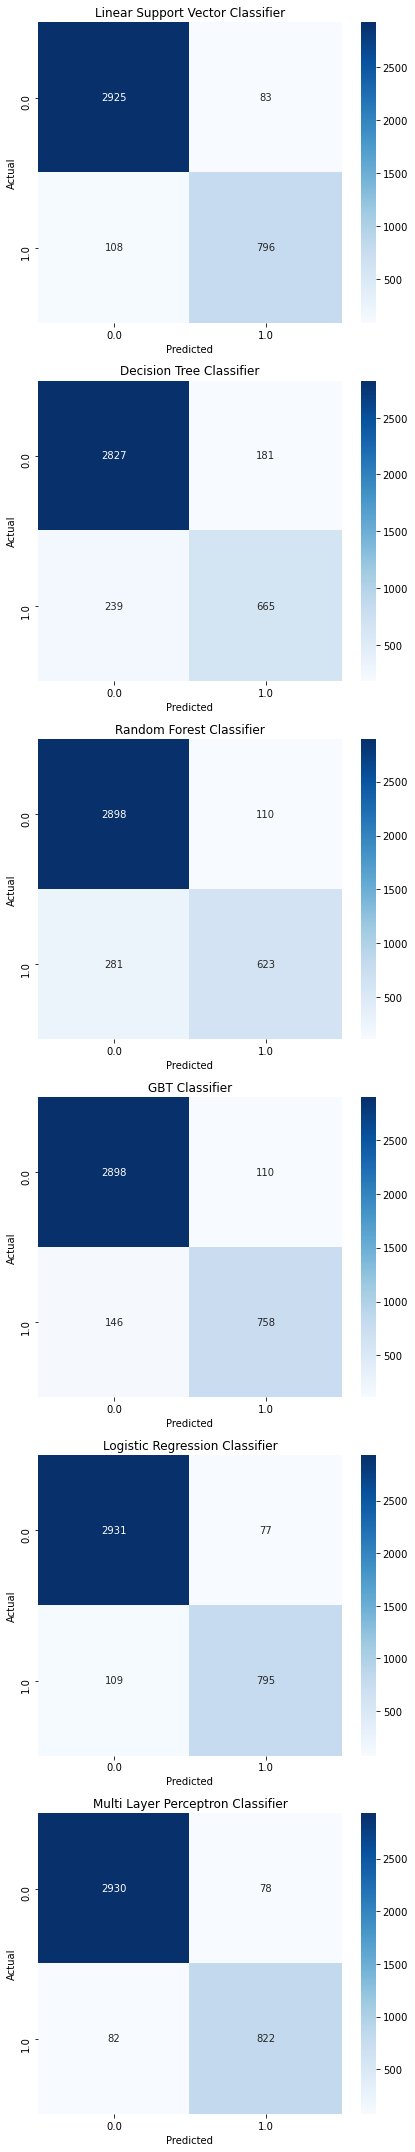

In [24]:
model_preds = {"Linear Support Vector Classifier": predictions_sv,
               "Decision Tree Classifier": predictions_dt,
               "Random Forest Classifier": predictions_rf,
               "GBT Classifier": predictions_gbt,
               "Logistic Regression Classifier": predictions_lr,
               "Multi Layer Perceptron Classifier": predictions_mlp}

plot_confusion_matrices(model_preds, labels=[0.0, 1.0]) 

In [25]:
def plot_accuracy_comparison(model_accuracies):
    # Extract model names and accuracies
    models = list(model_accuracies.keys())
    accuracies = list(model_accuracies.values())

    # Create bar chart of accuracies
    plt.figure(figsize=(6, 6))
    plt.bar(models, accuracies, color="#708090")

    # Title and labels
    plt.title("Model Accuracy Comparison", fontsize=16)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylim([0, 1])
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

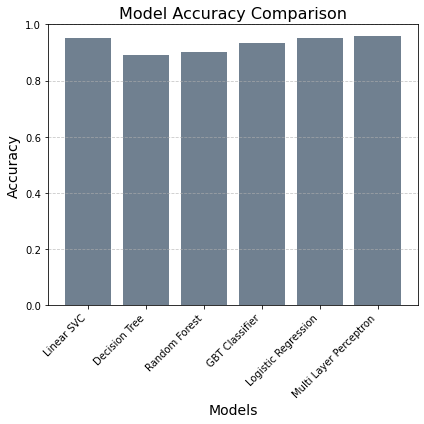

In [26]:
model_accuracies = {"Linear SVC": accuracy_sv,
                    "Decision Tree": accuracy_dt,
                    "Random Forest": accuracy_rf,
                    "GBT Classifier": accuracy_gbt,
                    "Logistic Regression": accuracy_lr, 
                    "Multi Layer Perceptron": accuracy_mlp} 

plot_accuracy_comparison(model_accuracies)

## **Regression Task - Risk Score Prediction**

### Lasoo Regressor

In [27]:
# Create the Lasso Regression model (L1 regularization)
lasso = LinearRegression(featuresCol="features", labelCol="label",
                         regParam=0.1, elasticNetParam=1.0)

# Fit the model
lasso_model = lasso.fit(train_data_reg)

# Make predictions
predictions = lasso_model.transform(test_data_reg)

# Evaluate the model
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 13.1475
R^2: 0.7772


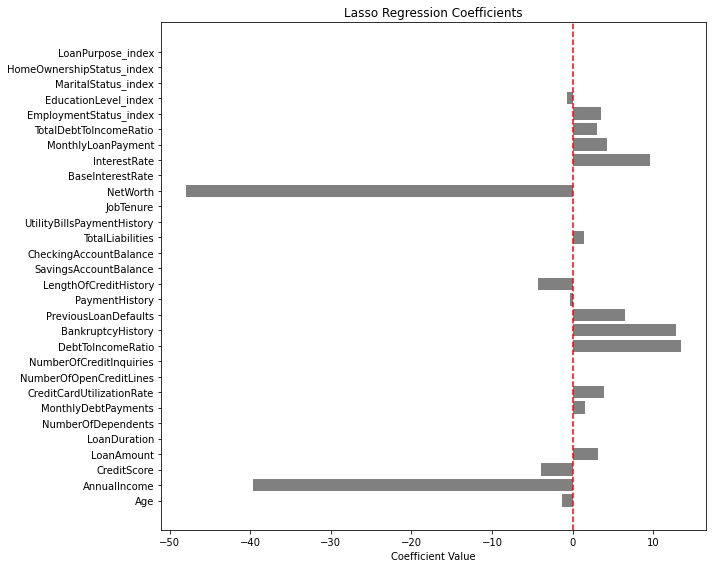

In [28]:
# Extract coefficients and intercept
coefficients = lasso_model.coefficients.toArray()
intercept = lasso_model.intercept

# Plot coefficients
plt.figure(figsize=(10, 8))
plt.barh(numerical_columns, coefficients, color='gray')
plt.xlabel("Coefficient Value")
plt.title("Lasso Regression Coefficients")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Gradient-Boosted Trees Regressor

In [29]:
# Define the GBT Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=5, seed=42)

# Train the model
gbt_model = gbt.fit(train_data_reg)

# Make predictions on the test data
predictions = gbt_model.transform(test_data_reg)

# Evaluate the model
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

mse = evaluator_mse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 6.8048
R^2: 0.8847
